In [1]:
import keras
import numpy as np

from keras.layers import Conv2D, Input, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
import keras.backend as K
from coord import CoordinateChannel2D

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from GeneratorClass import DataGeneratorEncoders_MLP, DataGeneratorEncoders_CNN

def get_data_by_ID(np_dict, ID):
    return np_dict["sample-{0}/noisy".format(ID)], np_dict["sample-{0}/orig".format(ID)]

def get_data_by_ID_orig(np_dict, ID):
    data = np_dict["sample-{0}/orig".format(ID)]
    return data, data

In [5]:
fileVer = 3
dataset_size = 10000
data_percentage = 1.

img_size = 64
n_width = img_size
n_height = img_size
n_depth = 1

#n_epochs = 70
#learning_rate = 1e-3
#lr_decay = 0.002
batch_size = 32

filePath = "G:\\Il mio Drive\\conquistiamo l'Universo\\Aurelio\\risoluzione_punti\\notebooks\\CNN autoencoder v{1}\\data\\img_{0}x{0}_v3\\img_{0}x{0}.npz".format(
    img_size, fileVer)
loaded = np.load(filePath)


def get_data_fn(ID):
    return get_data_by_ID(loaded, ID)

def get_data_orig_fn(ID):
    return get_data_by_ID_orig(loaded, ID)


In [6]:
# %% list of ids
total_dataset_size = int(dataset_size * data_percentage)

id_mask = np.arange(0, total_dataset_size)
np.random.shuffle(id_mask)

lista_ID_training = id_mask[0:int(0.7 * total_dataset_size)]
lista_ID_validation = id_mask[int(0.7 * total_dataset_size):int(0.8 * total_dataset_size)]
lista_ID_test = id_mask[int(0.8 * total_dataset_size):total_dataset_size]

create generators to feed data into model

In [8]:
params_CNN = {'get_data_fn': get_data_fn,
              'dim': (n_height, n_width),
              'batch_size': batch_size,
              'n_channels': n_depth,
              'shuffle': True}

VAE_generator_CNN_train = DataGeneratorEncoders_CNN(lista_ID_training, **params_CNN)
VAE_generator_CNN_val = DataGeneratorEncoders_CNN(lista_ID_validation, **params_CNN)
VAE_generator_CNN_test = DataGeneratorEncoders_CNN(lista_ID_test, **params_CNN)


In [9]:
np.max(VAE_generator_CNN_train.__getitem__(300))

0.0

# CNN

In [10]:
n_layers = 4
n_filters = [32,32, 64,64]
kernel_size = 3

input_layer = Input(shape=(n_height, n_width, n_depth), name="input_layer")
layer = input_layer
layer = CoordinateChannel2D()(layer)

#encoder


for i in range(n_layers):
    layer = Conv2D(filters=n_filters[i], kernel_size=kernel_size, strides=1, padding='valid', activation='relu',
                   name="conv_{0}".format(i))(layer)
    layer = BatchNormalization(name="batch_norm_enc_{}".format(i))(layer)

#decoder

for i in range(n_layers - 1, -1, -1):
    layer = Conv2DTranspose(filters=n_filters[i], kernel_size=kernel_size, strides=1, padding='valid',
                            activation='relu',
                            name="dec_conv_{0}".format(i))(layer)
    layer = BatchNormalization(name="batch_norm_dec_{}".format(i))(layer)

#build output layer
output_layer = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='linear',
                               name="output_layer")(layer)

model_CNN = Model(input_layer, output_layer)

#print summary of the model
model_CNN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 64, 64, 1)         0         
_________________________________________________________________
coordinate_channel2d_1 (Coor (None, 64, 64, 3)         0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_norm_enc_0 (BatchNorma (None, 62, 62, 32)        128       
_________________________________________________________________
conv_1 (Conv2D)              (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_norm_enc_1 (BatchNorma (None, 60, 60, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 58, 58, 64)        18496     
__________

In [26]:
learning_rate = 1e-4
lr_decay = 0.0

#compile model
model_CNN.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate, decay=lr_decay),
                  metrics=['accuracy'])

In [12]:
steps_per_epoch = len(VAE_generator_CNN_train)
steps_per_epoch_val = len(VAE_generator_CNN_val)

In [27]:
n_epochs=20

model_CNN.fit_generator(generator=VAE_generator_CNN_train, steps_per_epoch=steps_per_epoch,
                            validation_data=VAE_generator_CNN_val, validation_steps=steps_per_epoch_val,
                            epochs=n_epochs,
                            use_multiprocessing=True,
                            workers=0, verbose=1)

Epoch 1/20
218/218 [==============================] - 39s 180ms/step - loss: 2.5290e-04 - acc: 0.8465 - val_loss: 2.2352e-04 - val_acc: 0.8406
Epoch 2/20
218/218 [==============================] - 35s 163ms/step - loss: 1.8054e-04 - acc: 0.8465 - val_loss: 2.0510e-04 - val_acc: 0.8406
Epoch 3/20
218/218 [==============================] - 35s 162ms/step - loss: 1.5428e-04 - acc: 0.8465 - val_loss: 1.6877e-04 - val_acc: 0.8406
Epoch 4/20
218/218 [==============================] - 36s 163ms/step - loss: 1.3648e-04 - acc: 0.8465 - val_loss: 1.3872e-04 - val_acc: 0.8406
Epoch 5/20
218/218 [==============================] - 35s 163ms/step - loss: 1.2260e-04 - acc: 0.8465 - val_loss: 1.2051e-04 - val_acc: 0.8406
Epoch 6/20
218/218 [==============================] - 35s 162ms/step - loss: 1.1179e-04 - acc: 0.8465 - val_loss: 1.1004e-04 - val_acc: 0.8406
Epoch 7/20
218/218 [==============================] - 35s 163ms/step - loss: 1.0335e-04 - acc: 0.8465 - val_loss: 1.0293e-04 - val_acc: 0.8406

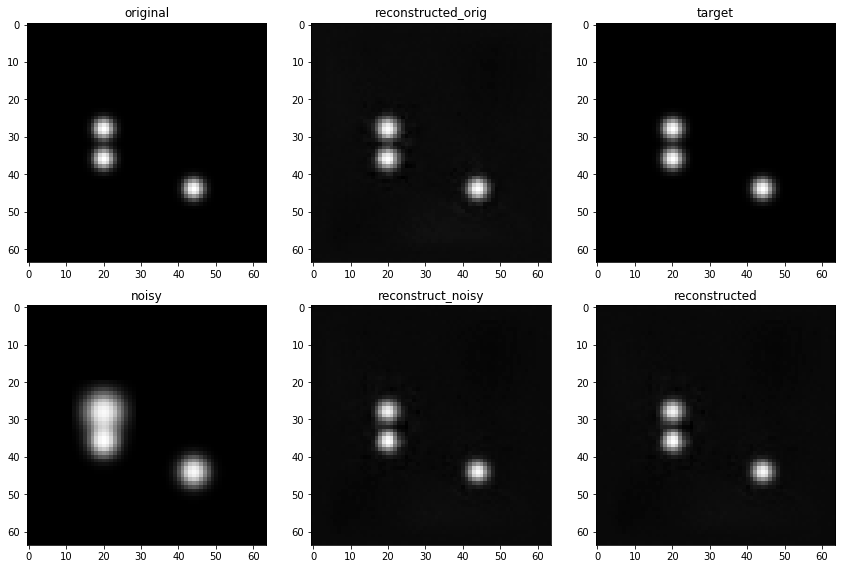

In [28]:
saple_id=40

data_tmp = np.array(VAE_generator_CNN_test.__getitem__(saple_id))[:,0,:,:,0]

X1_plt,X2_plt = data_tmp

X1=X1_plt.reshape((1,n_height,n_width,1))
X2=X2_plt.reshape((1,n_height,n_width,1))

Y_test_pred1 = model_CNN.predict(X1).reshape((n_height, n_width))
Y_test_pred2 = model_CNN.predict(X2).reshape((n_height, n_width))

fig2, axis2 = plt.subplots(2, 3, figsize=(12, 8))
axis2[0, 0].imshow(X2_plt, cmap="Greys_r")
axis2[0, 0].set_title("original")
axis2[1, 0].imshow(X1_plt, cmap="Greys_r")
axis2[1, 0].set_title("noisy")

axis2[0, 1].imshow(Y_test_pred2, cmap="Greys_r")
axis2[0, 1].set_title("reconstructed_orig")
axis2[1, 1].imshow(Y_test_pred1, cmap="Greys_r")
axis2[1, 1].set_title("reconstruct_noisy")

axis2[0, 2].imshow(X2_plt, cmap="Greys_r")
axis2[0, 2].set_title("target")
axis2[1, 2].imshow(Y_test_pred1, cmap="Greys_r")
axis2[1, 2].set_title("reconstructed")

fig2.tight_layout()
plt.show()

fig2.savefig("fig1.png")

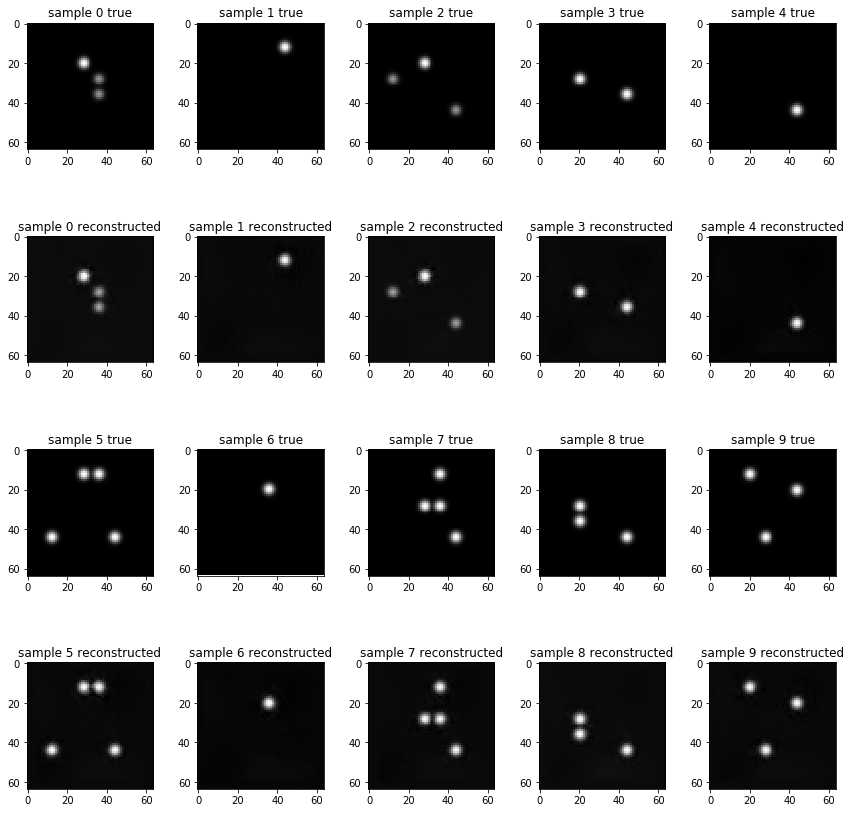

In [31]:
sample_ids=np.linspace(0,45,10,dtype=np.int32)

inputs=np.zeros((len(sample_ids),n_height, n_width))
reconstructed=np.zeros((len(sample_ids),n_height, n_width))

for i in np.arange(len(sample_ids)):

    data_tmp = np.array(VAE_generator_CNN_test.__getitem__(sample_ids[i]))[:,0,:,:,0]

    _,Xi_plt = data_tmp
    
    Xi=Xi_plt.reshape((1,n_height,n_width,1))

    Y_test_pred_i = model_CNN.predict(Xi).reshape((n_height, n_width))
    
    inputs[i,]=Xi_plt
    reconstructed[i,]=Y_test_pred_i 
    

fig3, axis3 = plt.subplots(4, 5, figsize=(12, 12
                                         ))
for i in range(5):
    axis3[0, i].imshow(inputs[i], cmap="Greys_r")
    axis3[0, i].set_title("sample {0} true".format(i))
    axis3[1, i].imshow(reconstructed[i], cmap="Greys_r")
    axis3[1, i].set_title("sample {0} reconstructed".format(i))
    
for i in range(5):
    axis3[2, i].imshow(inputs[i+5], cmap="Greys_r")
    axis3[2, i].set_title("sample {0} true".format(i+5))
    axis3[3, i].imshow(reconstructed[i+5], cmap="Greys_r")
    axis3[3, i].set_title("sample {0} reconstructed".format(i+5))    

fig3.tight_layout()
plt.show()
fig3.savefig("fig2.png")